<a href="https://colab.research.google.com/github/dileep5253/Community_Detection/blob/main/Community-Detection1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initialisation

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
#Import data set
df = pd.read_excel('/content/gdrive/MyDrive/OnlineRetail.xlsx', header = 0) # Changed path to /content/gdrive/MyDrive/OnlineRetail.xlsx

In [4]:
print('dataset dimensions are:', df.shape)
df.describe(include = 'all')


dataset dimensions are: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.0,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900.0,4070,4223,NaN,NaN,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom
freq,1114.0,2313,2369,NaN,NaN,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570,NaN
min,NaN,NaN,NaN,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,2011-03-28 11:34:00,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,2011-07-19 17:17:00,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,2011-10-19 11:27:00,4.130000,16791.000000,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,NaN


In [5]:
#Taking a smaller set of the data to speed up computations
df_sample = df.iloc[:4000]
print(df_sample)

     InvoiceNo StockCode                          Description  Quantity  \
0       536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1       536365     71053                  WHITE METAL LANTERN         6   
2       536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3       536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4       536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...        ...       ...                                  ...       ...   
3995    536742     22558      CLOTHES PEGS RETROSPOT PACK 24          2   
3996    536742     22379             RECYCLING BAG RETROSPOT          1   
3997    536742     22470                HEART OF WICKER LARGE         1   
3998    536742     21211       SET OF 72 SKULL PAPER  DOILIES         1   
3999    536742     22469                HEART OF WICKER SMALL         2   

             InvoiceDate  UnitPrice  CustomerID         Country  
0    2010-12-01 08:26:00       2.

## Data Pre-processing

In [6]:
#Delete rows with no Customer ID (if there is such a case)
cleaned_retail = df_sample.loc[pd.isnull(df_sample.CustomerID)==False]

#Create a lookup table
item_lookup = cleaned_retail[['StockCode', 'Description']].drop_duplicates()
item_lookup['StockCode'] = item_lookup.StockCode.astype(str)

#Data cleaning' to raw data
cleaned_retail['CustomerID'] = cleaned_retail.CustomerID.astype(int)
cleaned_retail = cleaned_retail[['StockCode', 'Quantity', 'CustomerID']]
grouped_cleaned = cleaned_retail.groupby(['CustomerID', 'StockCode']).sum().reset_index()
print()
grouped_cleaned.Quantity.loc[grouped_cleaned.Quantity == 0] = 1
grouped_purchased = grouped_cleaned.query('Quantity > 0')


<ipython-input-6-a50eeca40dda>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_retail['CustomerID'] = cleaned_retail.CustomerID.astype(int)
<ipython-input-6-a50eeca40dda>:13: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to 

In [7]:
#Count number of products and number of customers in the reduced dataset
no_products = len(grouped_purchased.StockCode.unique())
no_customers = len(grouped_purchased.CustomerID.unique())
print('Number of customers in dataset:', no_customers)
print('Number of products in dataset:', no_products)

Number of customers in dataset: 137
Number of products in dataset: 1131


## Create a Bipartite Graph

In [8]:
#Turn raw data to pivot ('ratings' matrix)
ratings = grouped_purchased.pivot(index = 'CustomerID', columns='StockCode', values='Quantity').fillna(0).astype('int')
#Binarize the ratings matrix (indicate only if a customer has purchased a product or not)
ratings_binary = ratings.copy()
ratings_binary[ratings_binary != 0] = 1
print(ratings)

StockCode   10002  10125  10133  10135  16014  16016  16046  16235  16237  \
CustomerID                                                                  
12431           0      0      0      0      0      0      0      0      0   
12433           0      0      0      0      0      0      0      0      0   
12583          48      0      0      0      0      0      0      0      0   
12662           0      0      0      0      0      0      0      0      0   
12748           0      0      0      0      0      0      0      0      0   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
18041           0      0      0      0      0      0      1      0      0   
18074           0      0      0      0      0      0      0      0      0   
18085           0      0      0      0      0      0      0      0      0   
18144           0      0      0      0      0      0      0      0      0   
18229           0      0      0      0      0      0      0      0      0   

## Convert to a Weighted Product Graph

In [9]:
import numpy as np

# Compute product interaction matrix using matrix multiplication
products_integer = np.dot(ratings_binary.T, ratings_binary)

# Set diagonal to zero (self-pairing not needed)
np.fill_diagonal(products_integer, 0)

# Print the interaction matrix
print(products_integer)


[[0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [10]:
#Count how many customers have purchased each item
print('Counting how many times each individual product has been purchased...')
times_purchased = products_integer.sum(axis = 1)
print(times_purchased)

Counting how many times each individual product has been purchased...
[30 73 27 ... 20 63 34]


In [11]:
#Construct final weighted matrix of item interactions
print('Building weighted product matrix...')
products_weighted = np.zeros((no_products,no_products))
for i in range(no_products):
    for j in range(no_products):
        if (times_purchased[i]+times_purchased[j]) !=0: #make sure you do not divide with zero
            products_weighted[i,j] = (products_integer[i,j])/(times_purchased[i]+times_purchased[j])
            products_weighted[j,i] = (products_integer[i,j])/(times_purchased[i]+times_purchased[j])
print(products_weighted)


Building weighted product matrix...
[[0.       0.       0.       ... 0.       0.       0.015625]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 ...
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.       0.       0.       ... 0.       0.       0.      ]
 [0.015625 0.       0.       ... 0.       0.       0.      ]]


## Visualise Weighted Product matrix

In [12]:
#Get list of item labels (instead of Codes)
nodes_codes = np.array(ratings_binary.columns).astype('str')
item_lookup_dict = pd.Series(item_lookup.Description.values,index=item_lookup.StockCode).to_dict()
nodes_labels = [item_lookup_dict[code] for code in nodes_codes]

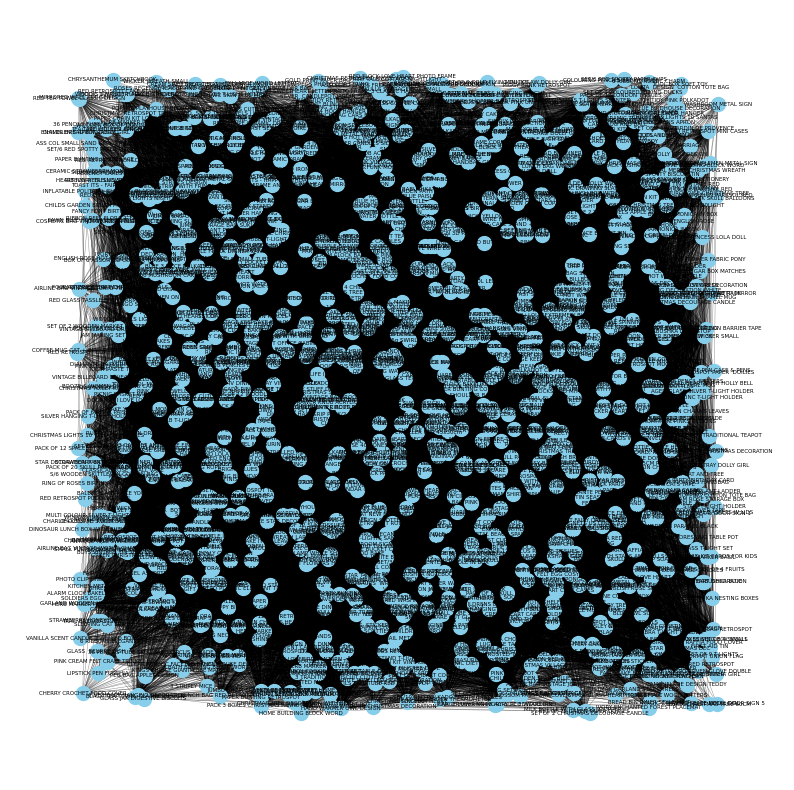

In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Assuming products_weighted is a 2D NumPy array (weighted adjacency matrix)
# and nodes_labels is a list of product names or descriptions.
# Example:
# products_weighted = np.array([[...], [...], ...]) # A weighted adjacency matrix
# nodes_labels = ['product1', 'product2', 'product3', ...]

G = nx.from_numpy_array(products_weighted)  # This creates a weighted graph from the matrix

pos = nx.random_layout(G)

labels = {idx: nodes_labels[idx] for idx in range(len(nodes_labels))}

plt.figure(figsize=(10, 10))

nx.draw_networkx_nodes(G, pos, node_color="skyblue", node_size=100)
nx.draw_networkx_edges(G, pos, edge_color='k', width=0.3, alpha=0.5)
nx.draw_networkx_labels(G, pos, labels, font_size=4)
plt.axis('off')
plt.show()


#### For better visualisation, export the graph to Gephi

In [14]:
#Export graph to Gephi
H=nx.relabel_nodes(G,labels) #create a new graph with Description labels and save to Gephi for visualizations
nx.write_gexf(H, "products.gexf")

## Louvain Clustering

Communities detected by Louvain method:
Community 1: [12, 16, 36, 46]
Community 2: [17, 27, 35, 39]
Community 3: [2, 5, 10, 13, 14, 22, 40, 45, 47]
Community 4: [3, 29, 31, 32, 41, 42]
Community 5: [4, 19, 23, 24]
Community 6: [1, 7, 25, 37]
Community 7: [8, 26, 28, 30, 38, 49]
Community 8: [6, 15, 21, 34, 43, 44, 48]
Community 9: [0, 9, 11, 18, 20, 33]


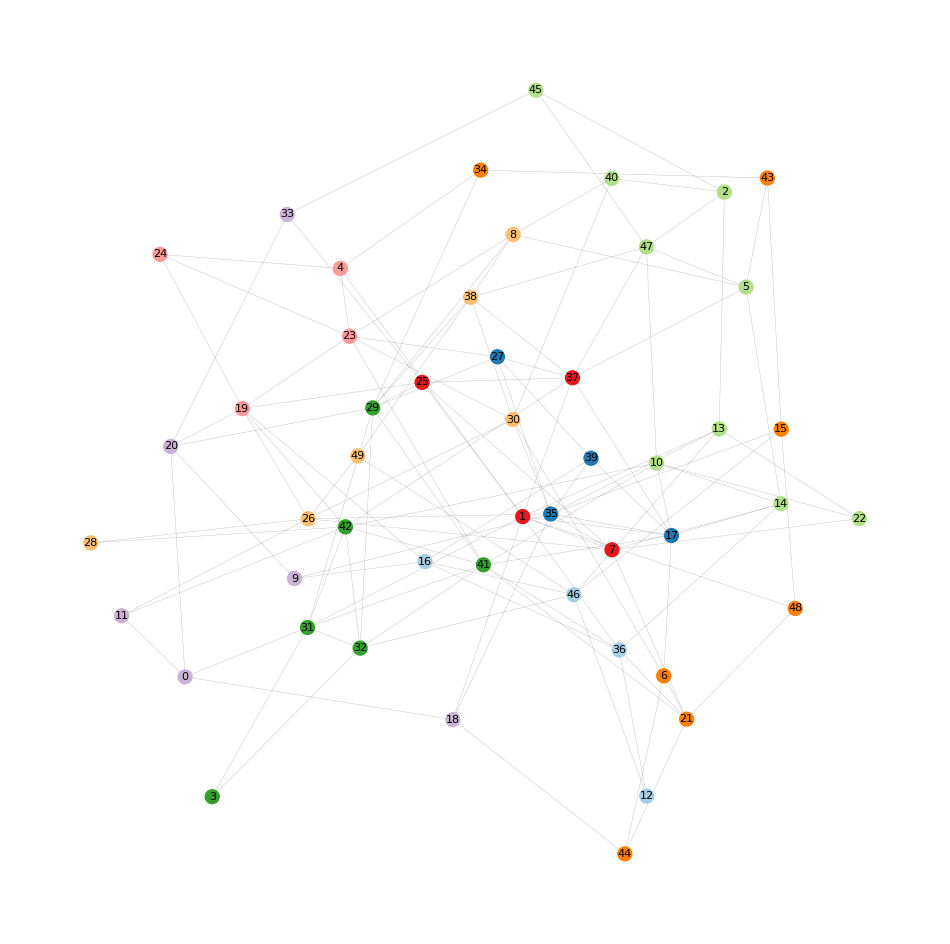

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain

# Function to get paired color palette for node coloring based on communities
def get_paired_color_palette(size):
    palette = []
    for i in range(size * 2):  # Generate enough colors
        palette.append(plt.cm.Paired(i))
    return palette

G = nx.erdos_renyi_graph(50, 0.1)  # Example: 50 nodes, 10% edge probability

# Apply the Louvain method for community detection
louvain = community_louvain.best_partition(G, resolution=1.5)
values = list(louvain.values())  # List of community assignments for each node

# Initialize an empty list to store communities
communities = []

# Loop over each unique community ID to group the nodes in each community
for i in set(louvain.values()):
    nodelist = [n for n in G.nodes if louvain[n] == i]
    communities.append(nodelist)

# Print the communities
print("Communities detected by Louvain method:")
for idx, community in enumerate(communities):
    print(f"Community {idx + 1}: {community}")

palette = get_paired_color_palette(len(communities))

# Visualize the graph
plt.figure(figsize=(12, 12))
node_colors = [palette[values[node]] for node in G.nodes]
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=100)
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.3, alpha=0.5)
labels = {node: str(node) for node in G.nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.axis('off')

# Show the plot
plt.show()


## Visualise detected communities

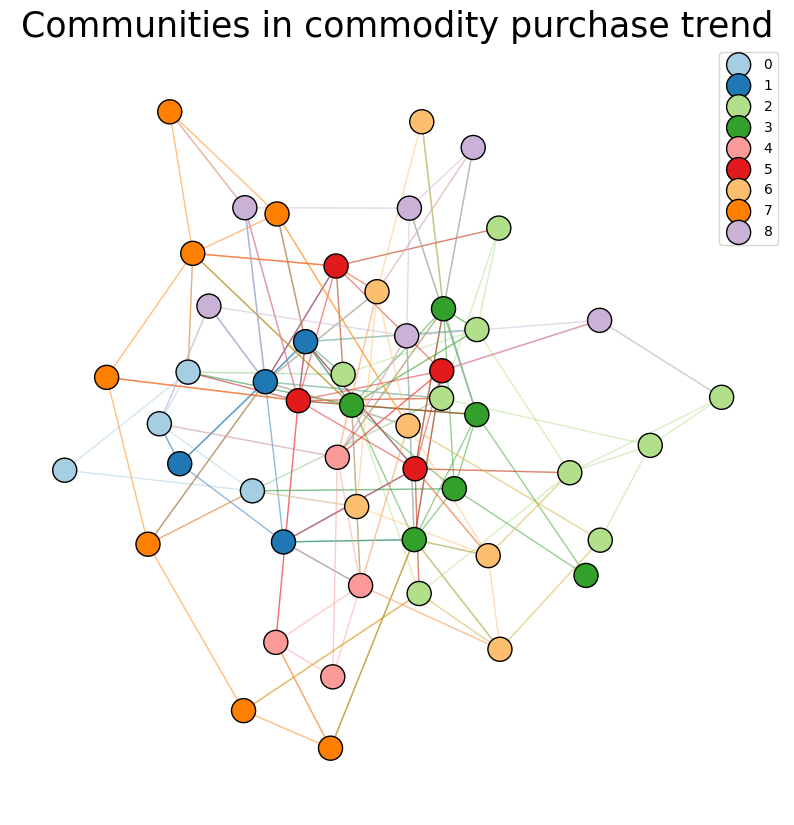

In [16]:
#make plot using matplotlib, networkx spring_layout, set_colors using cluster_count and get_paired_color_pallette
clusters_count = len(set(louvain.values()))
plt.figure(figsize=(10, 10))
light_colors = get_paired_color_palette(clusters_count)
dark_colors = get_paired_color_palette(clusters_count)
g = nx.drawing.layout.spring_layout(G, weight = 'weight')

for i in set(louvain.values()):
    nodelist = [n for n in G.nodes if (louvain[n]==i)]
    edgelist = [e for e in G.edges if ((louvain[e[0]]==i) or (louvain[e[1]]==i))]
    node_color = [light_colors[i] for _ in range(len(nodelist))]
    edge_color = [dark_colors[i] for _ in range(len(edgelist))]
    nx.draw_networkx_nodes(G, g, nodelist=nodelist, node_color=node_color, edgecolors='k', label = i)
    nx.draw_networkx_edges(G, g, edgelist=edgelist, alpha=.5, edge_color=edge_color)

#set title, legend and show plot
plt.title('Communities in commodity purchase trend', fontdict={'fontsize': 25})
plt.legend()
plt.axis('off')
plt.show()

## Performance Metrics

In [17]:
!pip install python-igraph
!pip install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.6 MB/s eta 0:00:00


Louvain Modularity Score: 0.5245


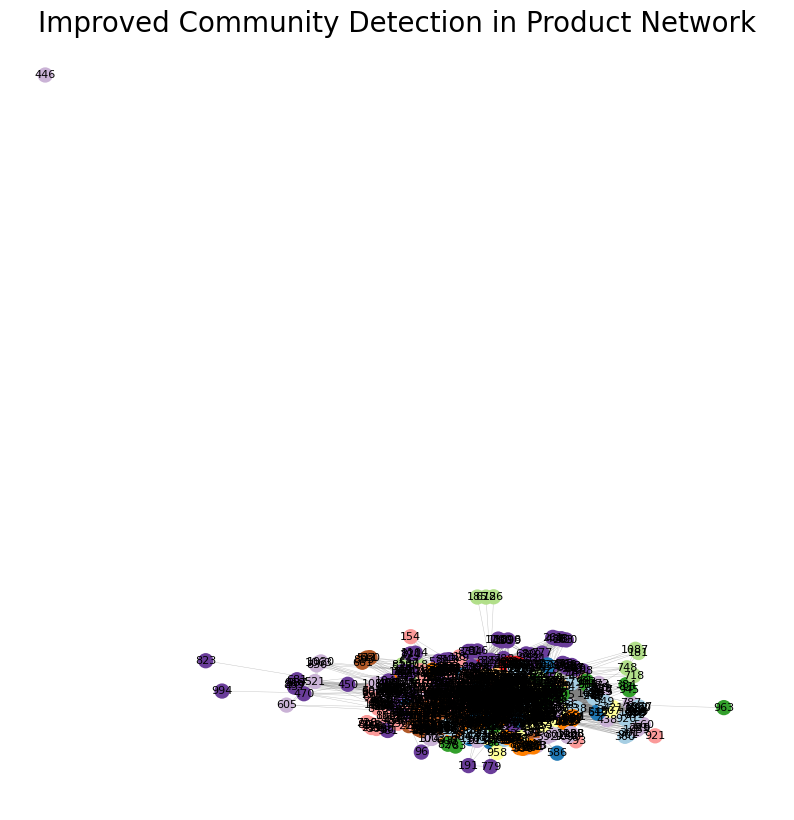

In [18]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
from sklearn.metrics.pairwise import cosine_similarity

# 🔹 Step 1: Compute Weighted Graph Using Cosine Similarity
product_similarity = cosine_similarity(ratings_binary.T)  # Compute similarity
np.fill_diagonal(product_similarity, 0)  # Remove self-similarity

# Create a graph with weighted edges
G = nx.from_numpy_array(product_similarity)

# 🔹 Step 2: Prune Weak Edges (Reduces Noise, Improves Community Separation)
threshold = 0.05  # Adjust threshold (try between 0.05 - 0.1)
edges_to_remove = [(u, v) for u, v, w in G.edges(data=True) if w['weight'] < threshold]
G.remove_edges_from(edges_to_remove)

# 🔹 Step 3: Apply Louvain Algorithm with Higher Resolution
louvain_partition = community_louvain.best_partition(G, resolution=2.0)

# 🔹 Step 4: Convert Louvain Partition to Clusters
louvain_clusters = [set() for _ in range(len(set(louvain_partition.values())))]
for node, cluster_id in louvain_partition.items():
    louvain_clusters[cluster_id].add(node)

# 🔹 Step 5: Compute & Print Modularity Score
modularity_louvain = nx.community.modularity(G, louvain_clusters)
print(f"Louvain Modularity Score: {modularity_louvain:.4f}")

# 🔹 Step 6: Visualize the Communities
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, weight="weight")

node_colors = [louvain_partition[node] for node in G.nodes]
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.Paired, node_size=100)
nx.draw_networkx_edges(G, pos, edge_color="gray", width=0.3, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=8)

plt.title("Improved Community Detection in Product Network", fontsize=20)
plt.axis("off")
plt.show()



## Detected Community Analysis

In [19]:
#Check how many communities were created
print('Number of communities:', len(np.unique(values)))

Number of communities: 9


In [20]:
# Apply the Louvain method to the products_weighted graph (assuming it's your main graph)
louvain = community_louvain.best_partition(nx.from_numpy_array(products_weighted), resolution=1.5)
values = list(louvain.values())

# Create dataframe with product description and community id
products_communities = pd.DataFrame(nodes_labels, columns=['product_description'])
products_communities['community_id'] = values  # Now 'values' should have the correct length
print(products_communities)

               product_description  community_id
0      INFLATABLE POLITICAL GLOBE             15
1          MINI FUNKY DESIGN TAPES             1
2     COLOURING PENCILS BROWN TUBE             2
3     COLOURING PENCILS BROWN TUBE             3
4      SMALL CHINESE STYLE SCISSOR             2
...                            ...           ...
1126     LETTER "S" BLING KEY RING            17
1127     LETTER "V" BLING KEY RING            17
1128                      CARRIAGE            22
1129                        Manual            23
1130                       POSTAGE            15

[1131 rows x 2 columns]


In [21]:
#Community 1
products_communities[products_communities['community_id']==1].head(40)

,product_description,community_id
1,MINI FUNKY DESIGN TAPES,1
47,BLUE ROSE FABRIC MIRROR,1
49,SET/9 CHRISTMAS T-LIGHTS SCENTED,1
102,SET/10 RED POLKADOT PARTY CANDLES,1
103,SET/10 PINK POLKADOT PARTY CANDLES,1
105,SET/10 BLUE POLKADOT PARTY CANDLES,1
160,SKULLS WRITING SET,1
161,BALLOONS WRITING SET,1
162,DINOSAURS WRITING SET,1
233,RETROSPOT SMALL TUBE MATCHES,1


## Target Advertising


In [23]:
import pandas as pd

# Sample Data: Customer-Product Purchases
df = pd.DataFrame({
    'CustomerID': [101, 101, 102, 103, 104, 105, 106, 107, 108, 109],
    'ProductID': ['A', 'B', 'A', 'C', 'D', 'E', 'A', 'D', 'B', 'C']
})

# Sample Product Community Data
products_communities = pd.DataFrame({
    'product_description': ['A', 'B', 'C', 'D', 'E'],
    'community_id': [1, 1, 2, 2, 3]  # Assigning communities to products
})

# Assign customers to detected product communities
def get_customer_community(customer_id, df, products_communities):
    products_bought = df[df['CustomerID'] == customer_id]['ProductID']
    communities = products_communities.loc[products_communities['product_description'].isin(products_bought), 'community_id']

    if not communities.empty:
        return communities.mode().iloc[0]  # Select the most common community
    return None  # Return None if no community is found

# Apply function to determine each customer's community
df['CustomerCommunity'] = df['CustomerID'].apply(lambda x: get_customer_community(x, df, products_communities))

# Drop duplicate CustomerID rows for clear output
print(df[['CustomerID', 'CustomerCommunity']].drop_duplicates())


   CustomerID  CustomerCommunity
0         101                  1
2         102                  1
3         103                  2
4         104                  2
5         105                  3
6         106                  1
7         107                  2
8         108                  1
9         109                  2


In [26]:
import random

def recommend_products(customer_id, products_communities):
    """
    Recommends products to a customer based on their community.

    Args:
        customer_id: The ID of the customer.
        products_communities: DataFrame containing product descriptions and their communities.

    Returns:
        A list of recommended product descriptions.
    """

    # Get the customer's community (using your existing get_customer_community function)
    customer_community = get_customer_community(customer_id, df, products_communities)

    # If the customer has a community assigned
    if customer_community is not None:
        # Recommend products from the same community
        recommended_products = products_communities[products_communities['community_id'] == customer_community]['product_description'].tolist()
        return recommended_products[:5]  # Return top 5 recommendations, or adjust as needed

    return []  # If no community, return an empty list

# Get a sample size less than or equal to the number of unique customers
num_unique_customers = len(df['CustomerID'].unique())
sample_size = min(num_unique_customers, 10)  # Adjust 10 to your desired sample size

# Get the random sample
sample_customers = random.sample(df['CustomerID'].unique().tolist(), sample_size)

# Generate targeted ads for each customer
for customer_id in sample_customers:
    print(f"Targeted Ads for Customer {customer_id}: {recommend_products(customer_id, products_communities)}")

Targeted Ads for Customer 101: ['A', 'B']
Targeted Ads for Customer 104: ['C', 'D']
Targeted Ads for Customer 107: ['C', 'D']
Targeted Ads for Customer 109: ['C', 'D']
Targeted Ads for Customer 105: ['E']
Targeted Ads for Customer 108: ['A', 'B']
Targeted Ads for Customer 106: ['A', 'B']
Targeted Ads for Customer 102: ['A', 'B']
Targeted Ads for Customer 103: ['C', 'D']


In [27]:
#Saving the trained model for use in the UI
products_prob.to_csv('products_prob.csv')

NameError: name 'products_prob' is not defined

In [28]:
pip install networkx matplotlib


In [29]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a random graph (e.g., Erdos-Renyi graph)
G = nx.erdos_renyi_graph(50, 0.1)  # 50 nodes, 10% probability of an edge between nodes


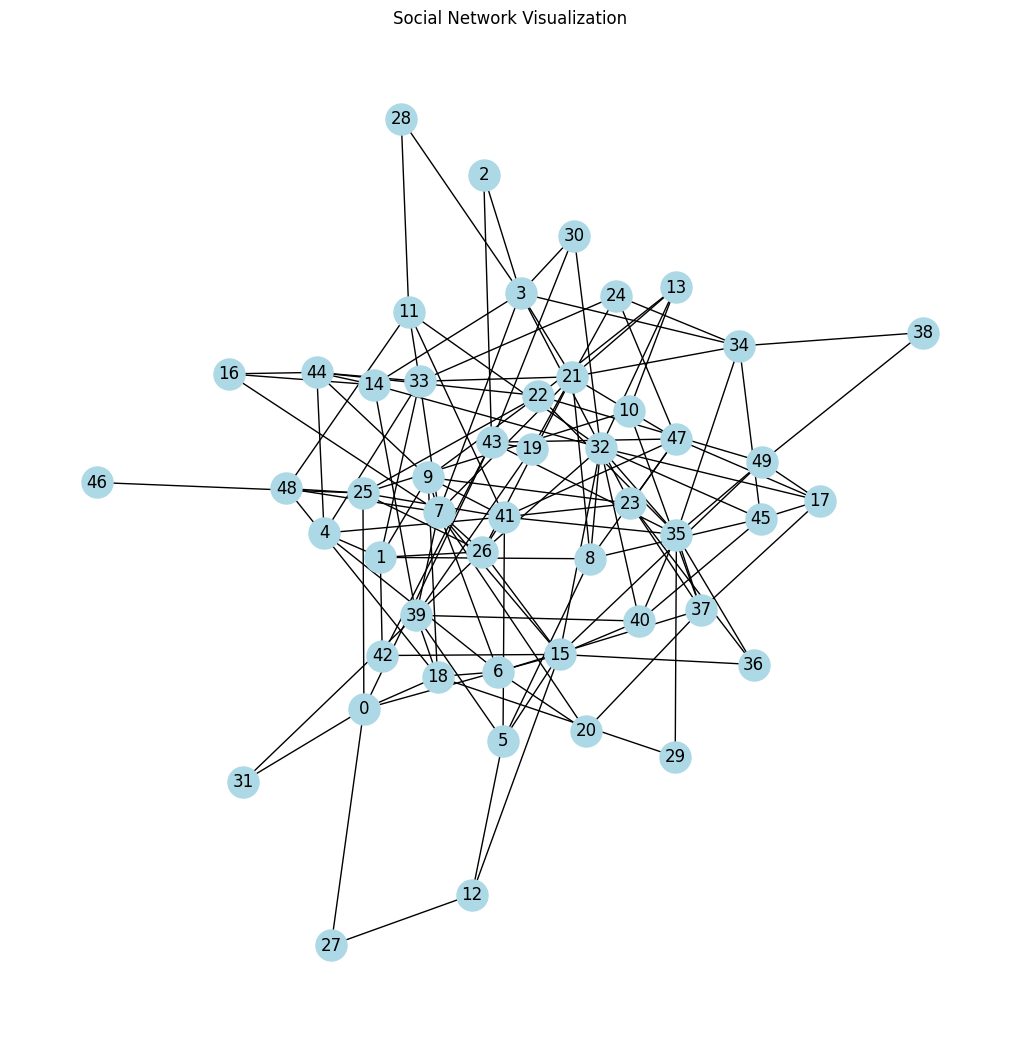

In [30]:
# Draw the network
plt.figure(figsize=(10, 10))  # Set the size of the plot
nx.draw(G, with_labels=True, node_size=500, node_color='lightblue', font_size=12)
plt.title("Social Network Visualization")
plt.show()


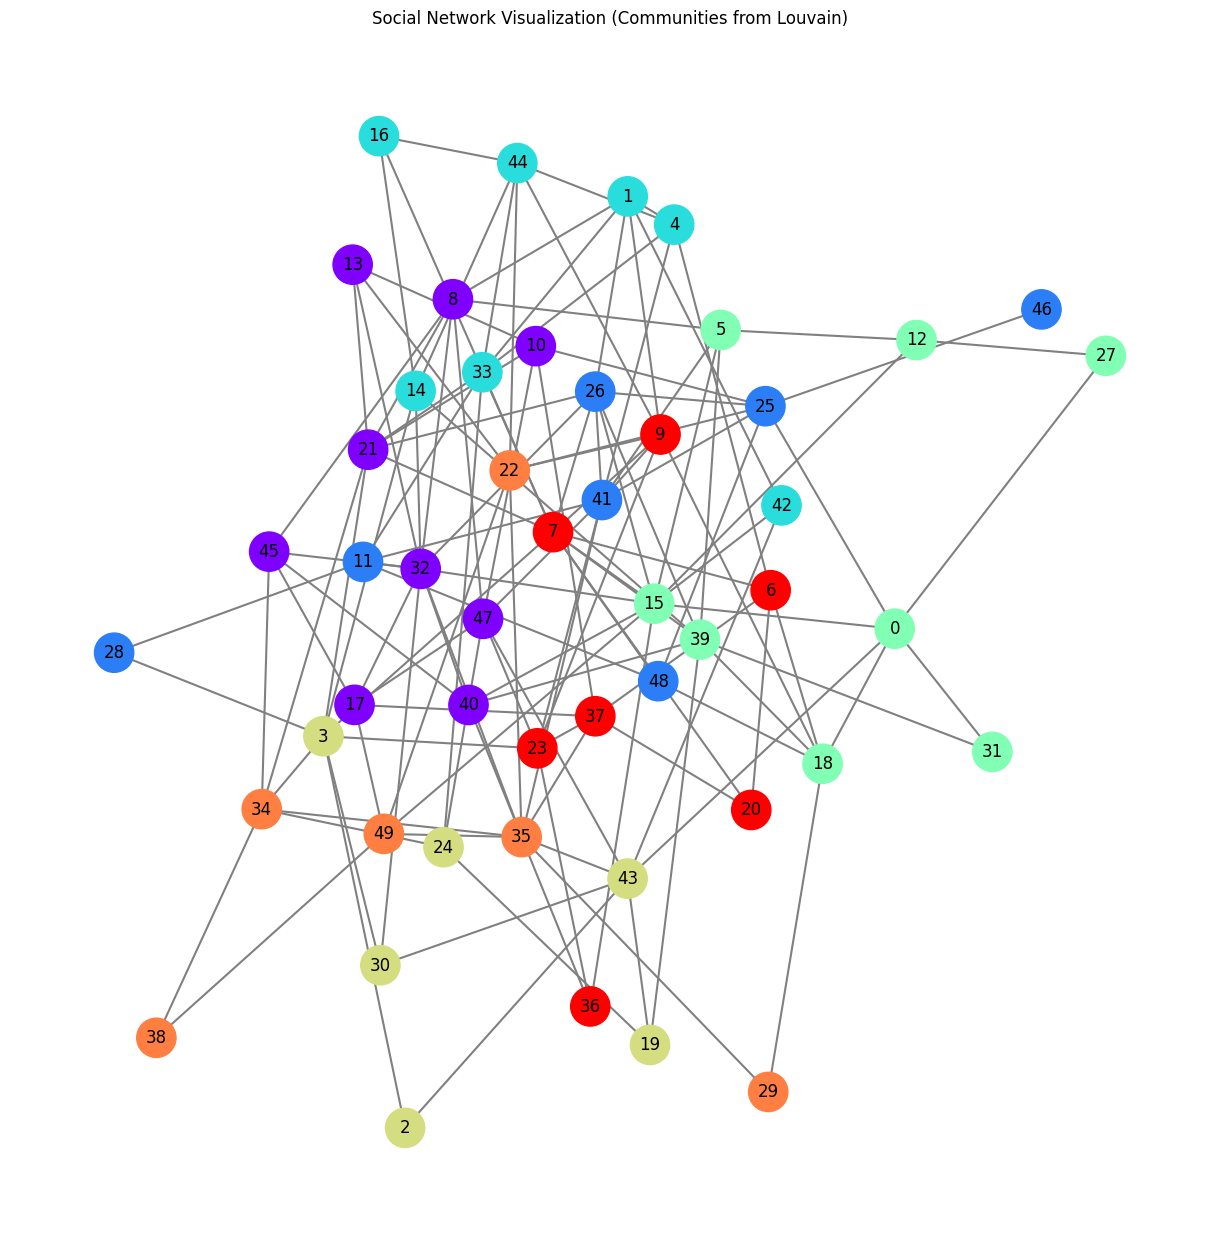

In [31]:
# Assuming you have already detected communities, like using the Louvain method
from community import community_louvain

# Detect communities (partition)
partition = community_louvain.best_partition(G)

# Color nodes based on community
community_color = [partition[node] for node in G.nodes]
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=800, node_color=community_color, cmap=plt.cm.rainbow, font_size=12, font_color='black', edge_color='gray', width=1.5)
plt.title("Social Network Visualization (Communities from Louvain)")
plt.show()


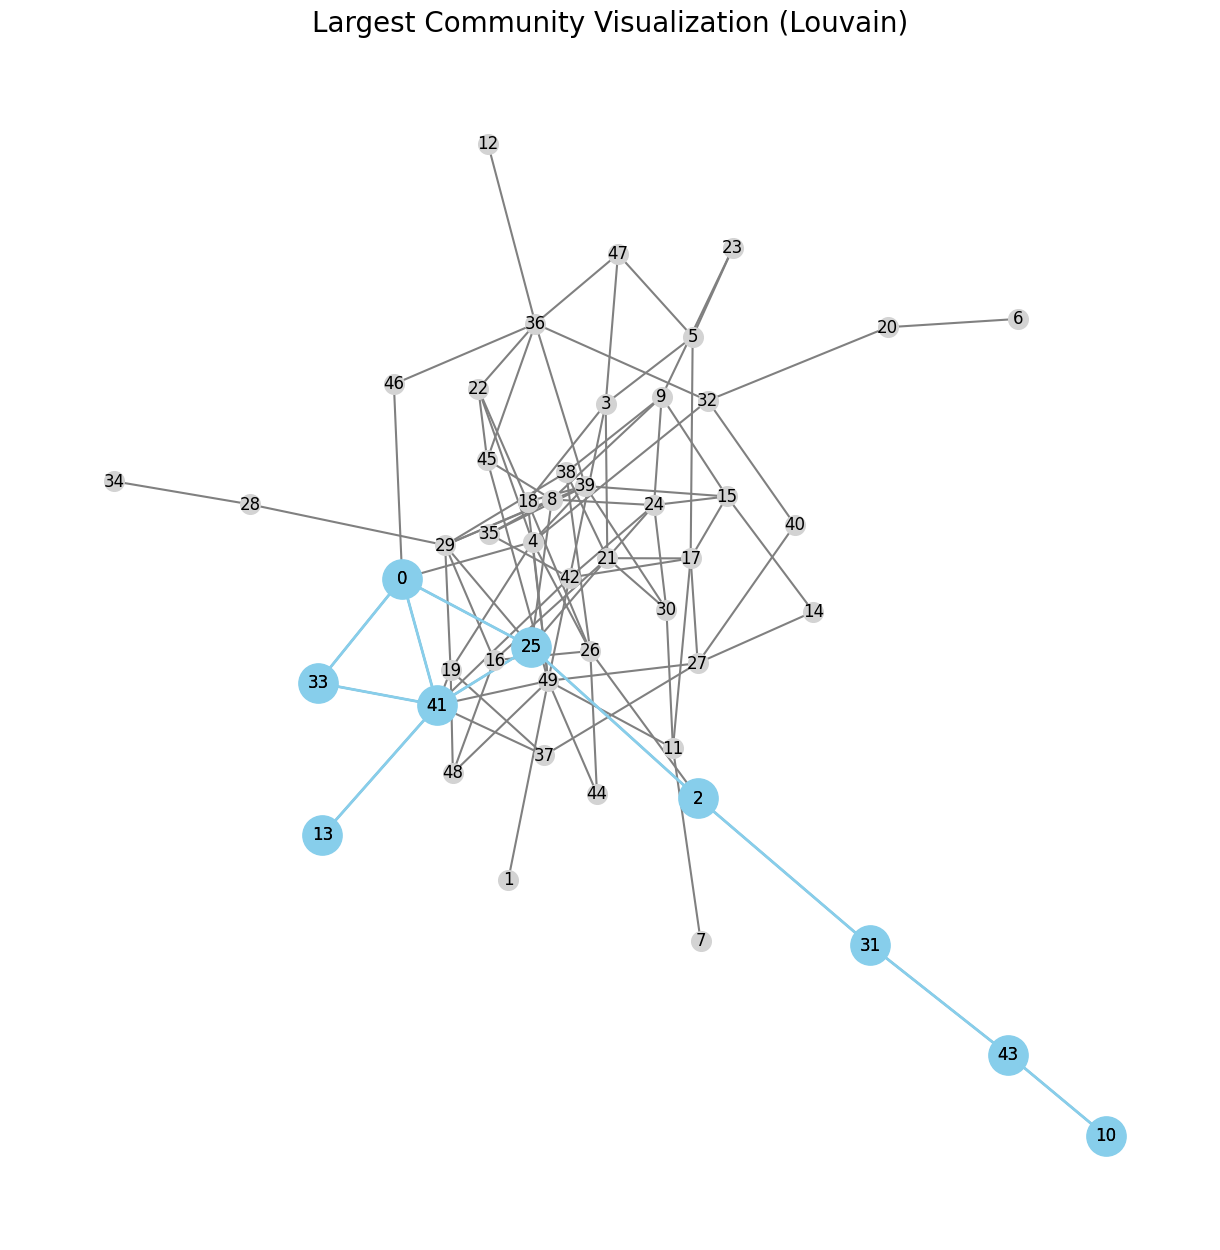

In [32]:

# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
# Import the community_louvain module directly
from community import community_louvain  # Louvain method for community detection

# Create a random graph (or replace it with your own graph)
G = nx.erdos_renyi_graph(50, 0.1)  # Example: 50 nodes with 10% probability for an edge

# Apply the Louvain method for community detection
partition = community_louvain.best_partition(G)

# Find the largest community
# Count the size of each community
community_sizes = {}
for node, community_id in partition.items():
    community_sizes[community_id] = community_sizes.get(community_id, 0) + 1

# Find the community with the maximum size
largest_community_id = max(community_sizes, key=community_sizes.get)

# Get the nodes belonging to the largest community
largest_community_nodes = [node for node, community_id in partition.items() if community_id == largest_community_id]

# Create a subgraph for the largest community
largest_community_subgraph = G.subgraph(largest_community_nodes)

# Choose a layout for visualization (Spring layout)
pos = nx.spring_layout(G, seed=42)  # Positions for nodes using spring layout

# Create the plot
plt.figure(figsize=(12, 12))

# Draw the entire graph with light gray nodes for background
nx.draw(G, pos, with_labels=True, node_size=200, node_color='lightgray', font_size=12, font_color='black', edge_color='gray', width=1.5)

# Then, draw the largest community with a distinct color (e.g., 'skyblue')
nx.draw(largest_community_subgraph, pos, with_labels=True, node_size=800, node_color='skyblue', font_size=12, font_color='black', edge_color='skyblue', width=2)

# Title for the plot
plt.title("Largest Community Visualization (Louvain)", fontsize=20)

# Show the plot
plt.show()


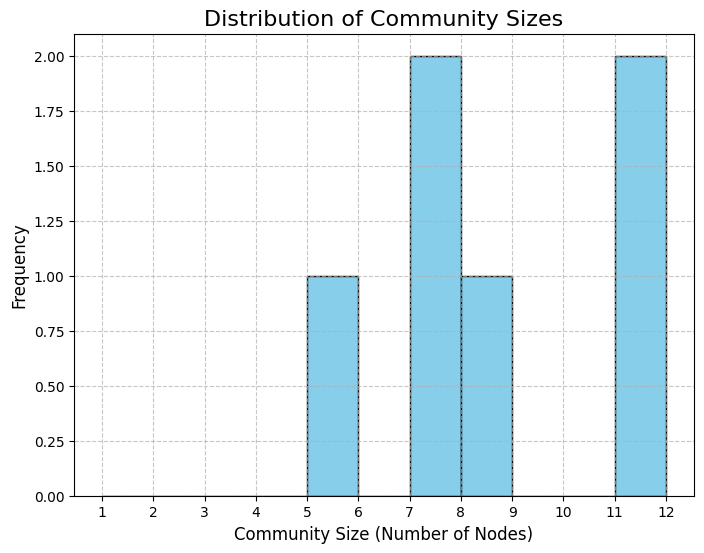

In [33]:
# Import necessary libraries
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain  # Louvain method for community detection

# Create a random graph (or replace it with your own graph)
G = nx.erdos_renyi_graph(50, 0.1)  # Example: 50 nodes with 10% probability for an edge

# Apply the Louvain method for community detection
partition = community_louvain.best_partition(G)

# Calculate the size of each community
community_sizes = {}
for node, community_id in partition.items():
    community_sizes[community_id] = community_sizes.get(community_id, 0) + 1

# Plot the distribution of community sizes
plt.figure(figsize=(8, 6))

# Plot a histogram of community sizes
plt.hist(community_sizes.values(), bins=range(1, max(community_sizes.values()) + 1), color='skyblue', edgecolor='black')

# Customize the plot
plt.title('Distribution of Community Sizes', fontsize=16)
plt.xlabel('Community Size (Number of Nodes)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(range(1, max(community_sizes.values()) + 1))
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [74]:
# Sample data for faster computation
df_sample = df.iloc[:4000]

# Create Graph from Transaction Data
G = nx.Graph()
for index, row in df_sample.iterrows():
    # Check if 'Quantity' and 'StockCode' columns exist before accessing them
    quantity = max(0, row['Quantity']) if 'Quantity' in row else 1  # Default to 1 if 'Quantity' is missing
    # Access 'ProductID' column instead of 'StockCode' (if 'StockCode' is missing)
    stock_code = row['StockCode'] if 'StockCode' in row else row['ProductID']
    G.add_edge(row['CustomerID'], stock_code, weight=quantity)

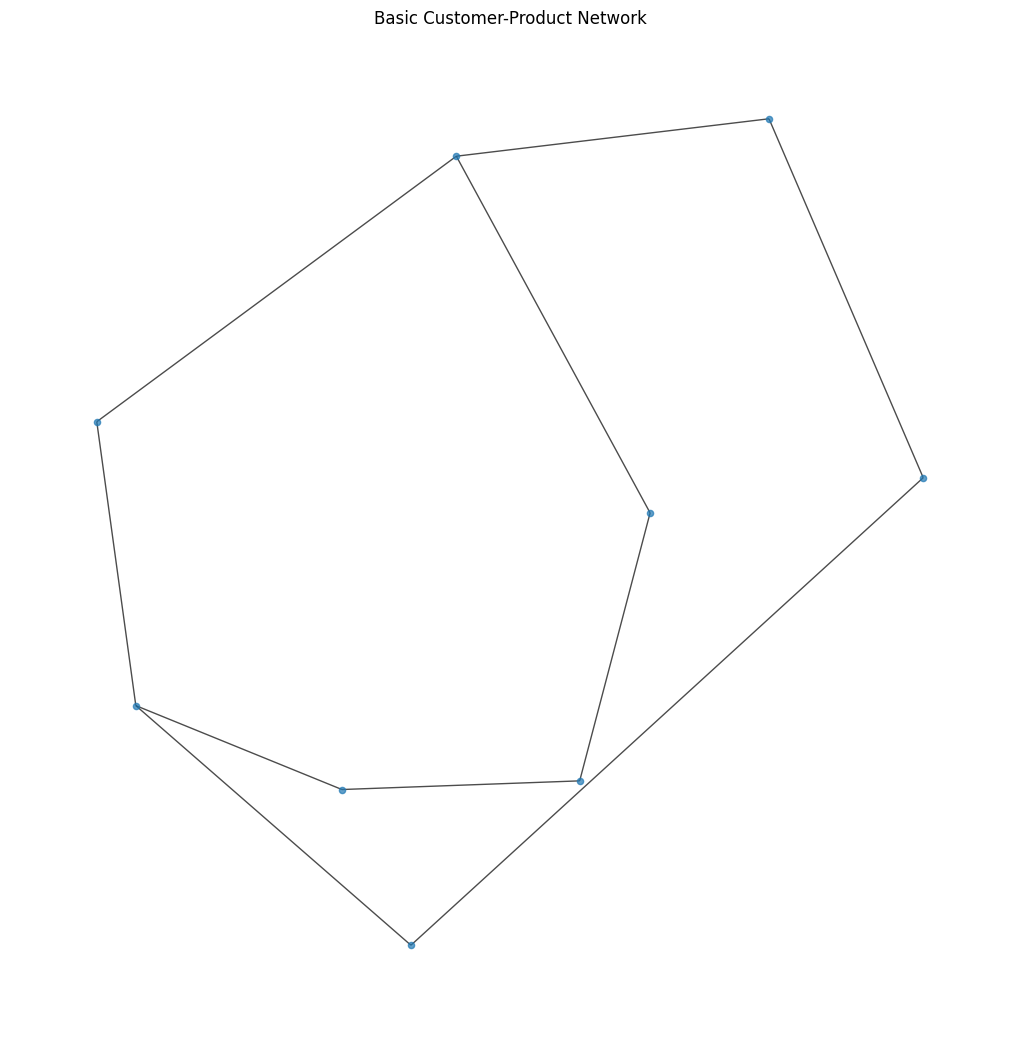

In [83]:
# Apply Community Detection
partition = community_louvain.best_partition(G)

# Visualization 1: Basic Network Graph
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=20, with_labels=False, alpha=0.7)
plt.title("Basic Customer-Product Network")
plt.show()

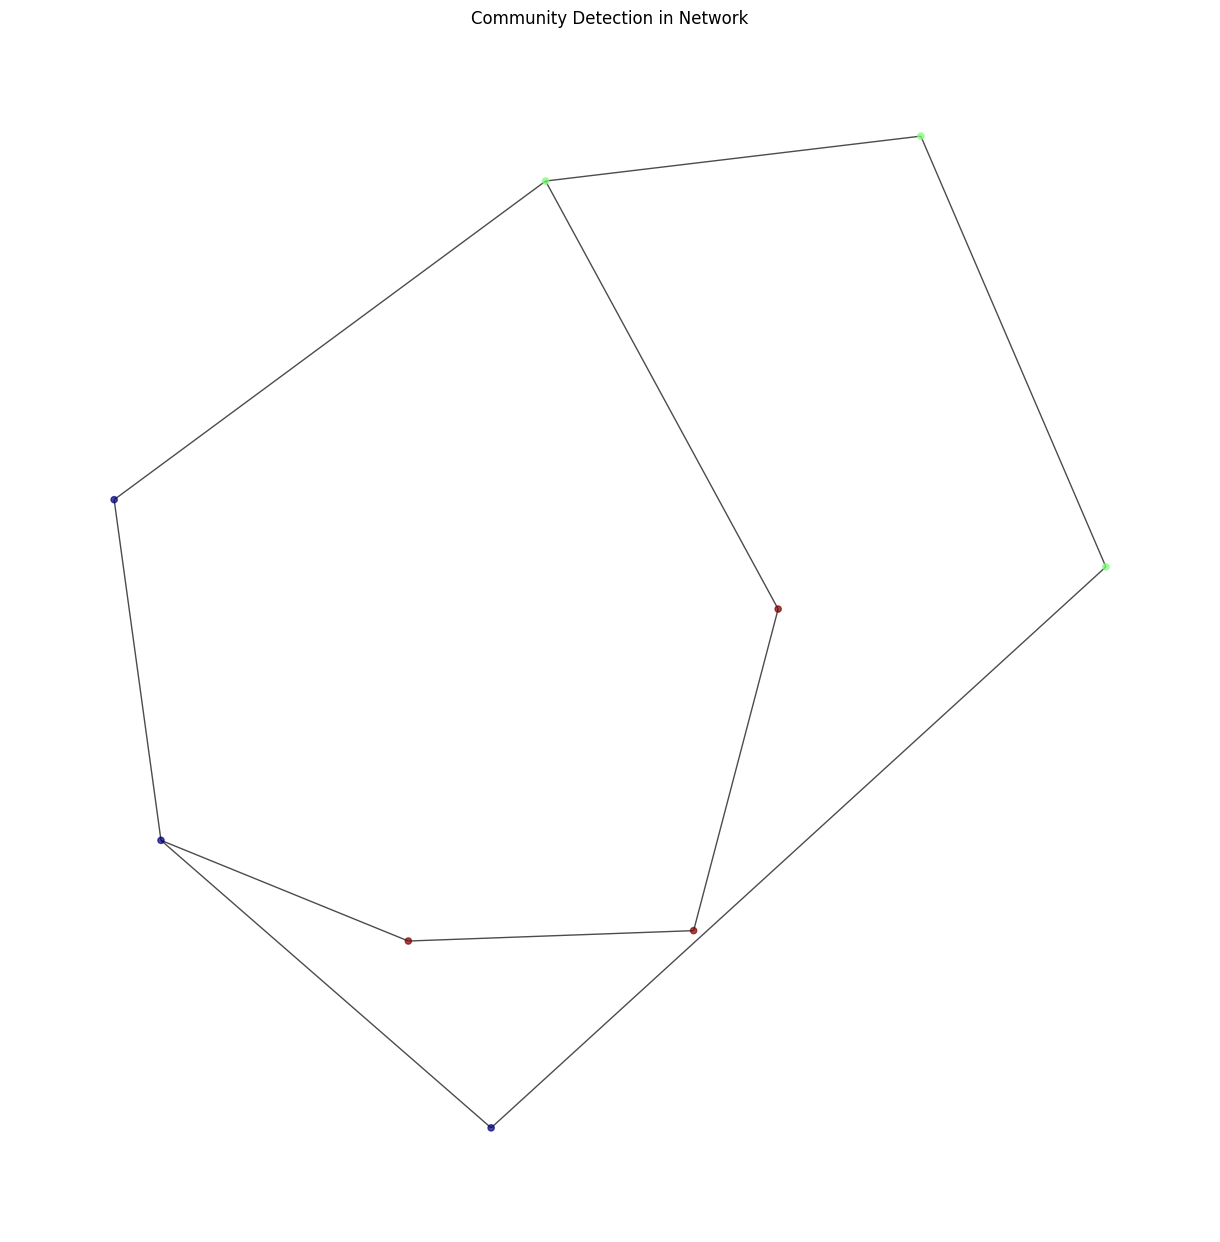

In [84]:
# Visualization 2: Community Detection Graph
plt.figure(figsize=(12, 12))
colors = [partition[node] if node in partition else 0 for node in G.nodes()]
nx.draw(G, pos, node_color=colors, node_size=20, with_labels=False, cmap=plt.cm.jet, alpha=0.7)
plt.title("Community Detection in Network")
plt.show()

In [82]:
!pip install pyvis

In [51]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from community import community_louvain
from pyvis.network import Network
import plotly.express as px
from IPython.display import display, HTML

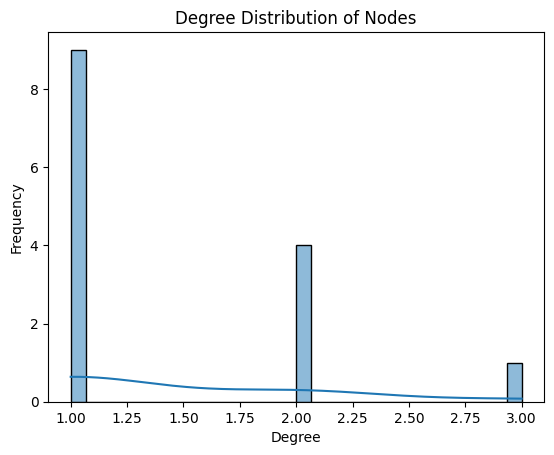

In [52]:
# Visualization 4: Degree Distribution
degrees = [val for (node, val) in G.degree()]
sns.histplot(degrees, bins=30, kde=True)
plt.title("Degree Distribution of Nodes")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [53]:
# Visualization 5: Centrality Analysis
centrality = nx.degree_centrality(G)
central_df = pd.DataFrame.from_dict(centrality, orient='index', columns=['Centrality'])
fig = px.histogram(central_df, x='Centrality', nbins=30, title="Centrality Distribution")
fig.show()


<ipython-input-54-6f5cba3b20d1>:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




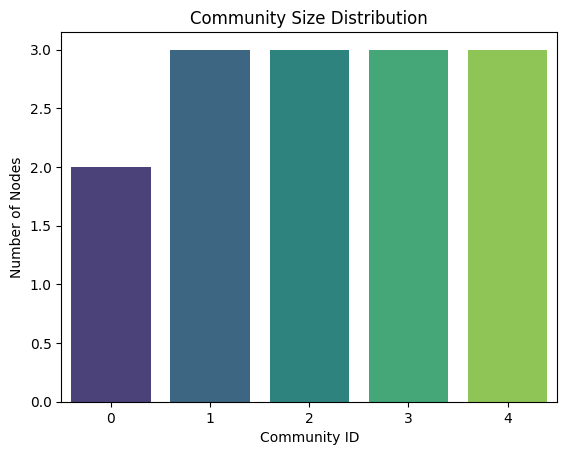

In [54]:
# Visualization 7: Community Size Distribution
community_sizes = pd.Series(list(partition.values())).value_counts()
sns.barplot(x=community_sizes.index, y=community_sizes.values, palette="viridis")
plt.title("Community Size Distribution")
plt.xlabel("Community ID")
plt.ylabel("Number of Nodes")
plt.show()

<ipython-input-57-c151031b4011>:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




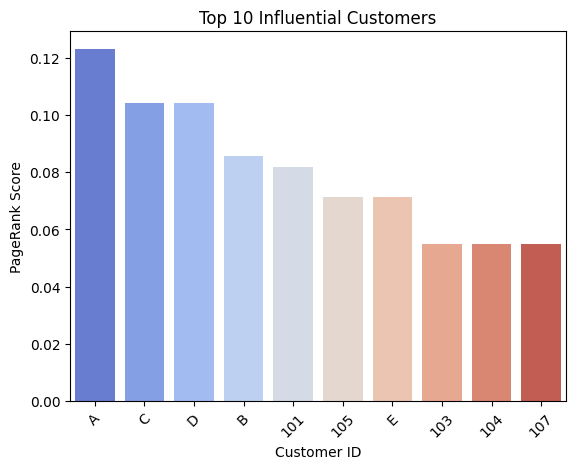

In [57]:
# Compute PageRank for Influential Customers
pagerank = nx.pagerank(G)
pagerank_df = pd.DataFrame.from_dict(pagerank, orient='index', columns=['PageRank'])
pagerank_df = pagerank_df.sort_values(by='PageRank', ascending=False)

# Visualization 6: Top Influential Customers
sns.barplot(x=pagerank_df.index[:10], y=pagerank_df['PageRank'][:10], palette="coolwarm")
plt.title("Top 10 Influential Customers")
plt.xlabel("Customer ID")
plt.ylabel("PageRank Score")
plt.xticks(rotation=45)
plt.show()


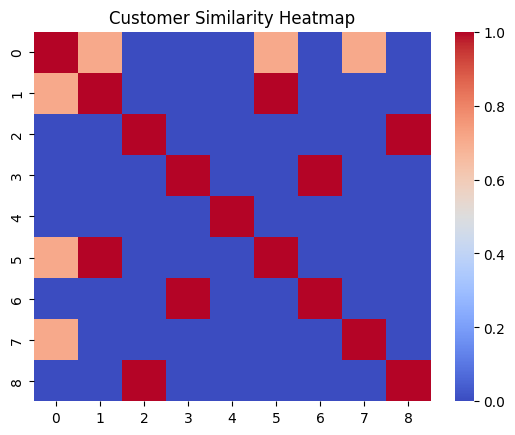

In [60]:
# Import necessary libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from community import community_louvain
from pyvis.network import Network
import plotly.express as px
from IPython.display import display, HTML
from scipy.spatial.distance import pdist, squareform # Import the squareform function

# Check if 'Quantity' column exists in df_sample
if 'Quantity' not in df_sample.columns:
    # If not, create it with default values (e.g., 1)
    df_sample['Quantity'] = 1

# Compute Customer Similarity Matrix
# Use 'ProductID' instead of 'StockCode' as the column name
customer_product_matrix = df_sample.pivot_table(index='CustomerID', columns='ProductID', values='Quantity', fill_value=0)
similarity_matrix = 1 - squareform(pdist(customer_product_matrix, metric='cosine'))
sns.heatmap(similarity_matrix, cmap='coolwarm')
plt.title("Customer Similarity Heatmap")
plt.show()

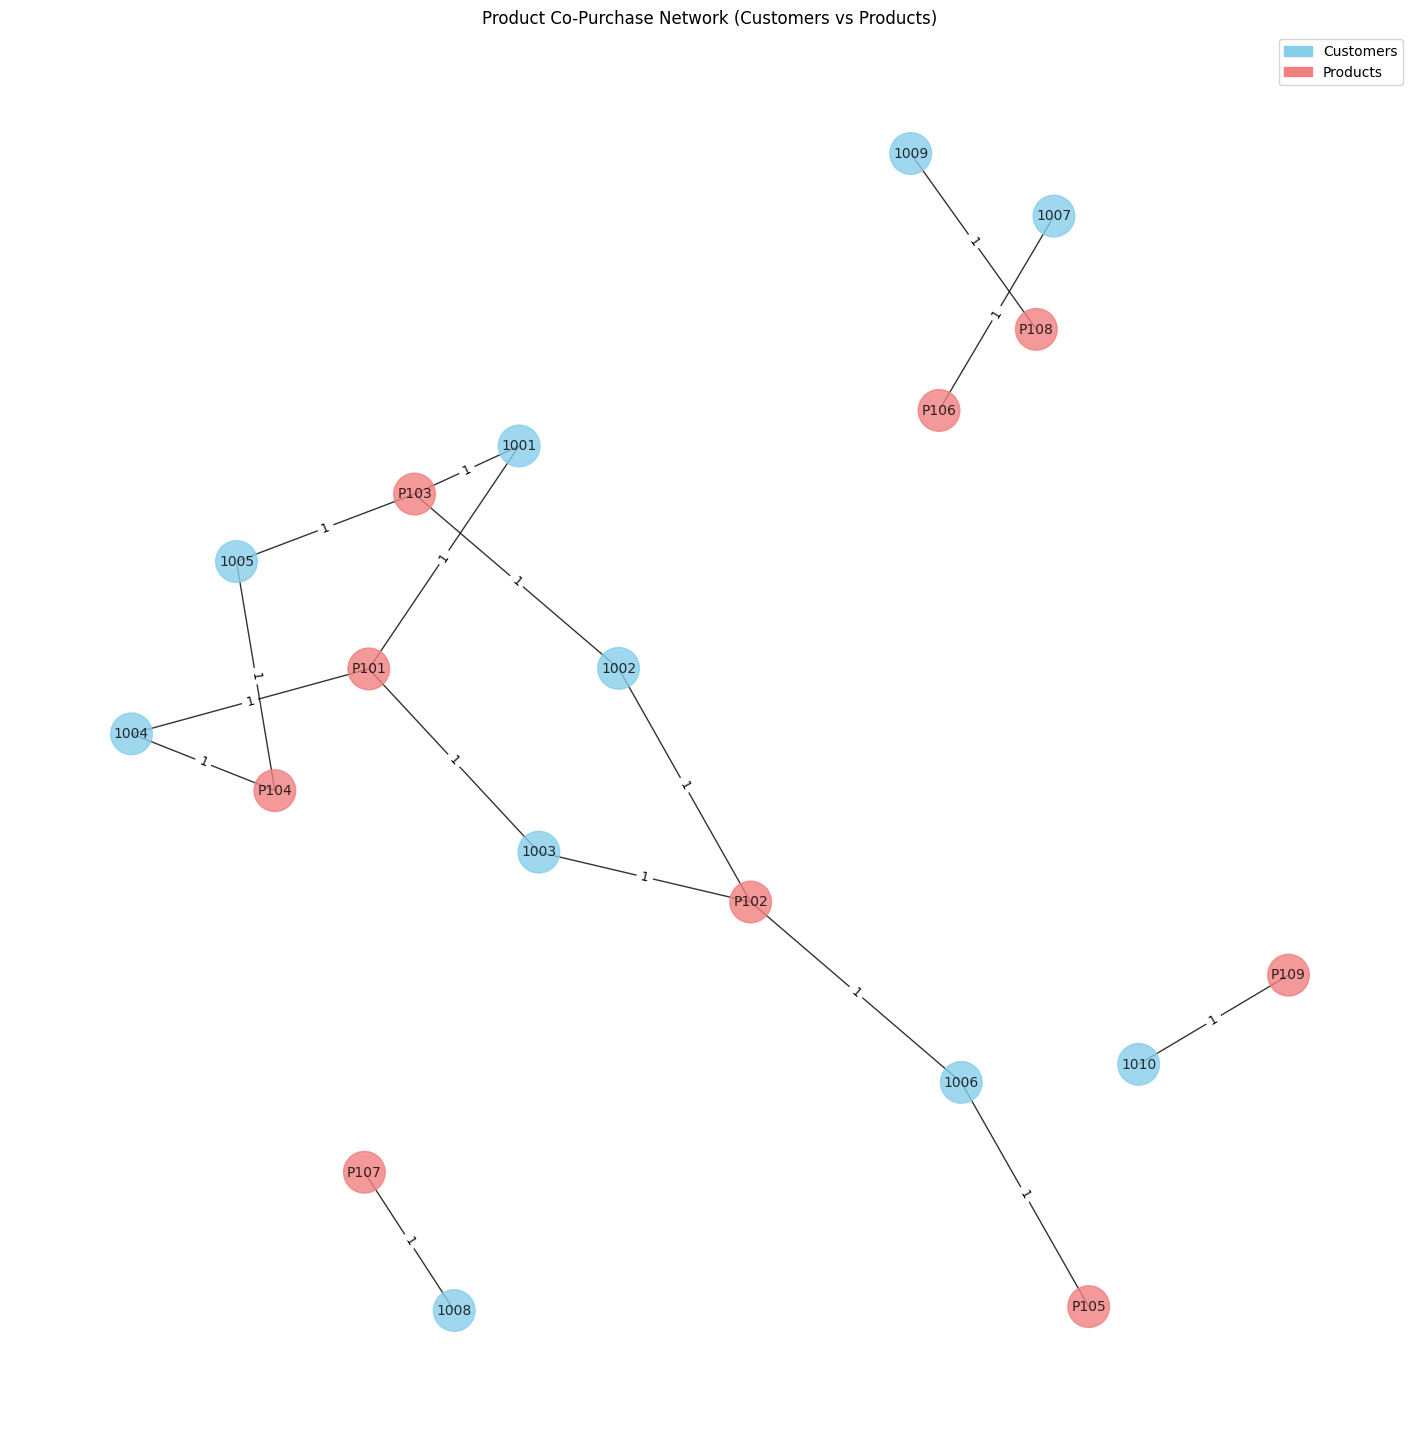

In [61]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Sample Data (Larger Dataset)
data = {
    'CustomerID': [1001, 1001, 1002, 1002, 1003, 1003, 1004, 1004, 1005, 1005, 1006, 1006, 1007, 1008, 1009, 1010],
    'StockCode': ['P101', 'P103', 'P102', 'P103', 'P101', 'P102', 'P101', 'P104', 'P103', 'P104', 'P102', 'P105', 'P106', 'P107', 'P108', 'P109']
}
df_sample = pd.DataFrame(data)

# Create Graph
product_G = nx.Graph()
product_pairs = df_sample.groupby(['StockCode', 'CustomerID']).size().reset_index()

# Add Nodes & Edges
for _, row in product_pairs.iterrows():
    product_G.add_edge(row['StockCode'], row['CustomerID'], weight=row[0])

# Set Different Colors for Customers and Products
node_colors = []
for node in product_G.nodes():
    if isinstance(node, int):  # Customers (IDs are integers)
        node_colors.append('skyblue')
    else:  # Products (StockCode)
        node_colors.append('lightcoral')

# Set Figure Size & Layout
plt.figure(figsize=(14, 14))
pos = nx.spring_layout(product_G, k=0.6, seed=42)  # Spread the nodes

# Draw Nodes with Different Colors
nx.draw(product_G, pos, node_size=900, node_color=node_colors, alpha=0.8, with_labels=True, font_size=10, font_color='black')

# Add Edge Labels (Co-Purchase Counts)
edge_labels = {(row['StockCode'], row['CustomerID']): str(row[0]) for _, row in product_pairs.iterrows()}
nx.draw_networkx_edge_labels(product_G, pos, edge_labels=edge_labels, font_size=9)

# Add Legend
import matplotlib.patches as mpatches
customer_patch = mpatches.Patch(color='skyblue', label='Customers')
product_patch = mpatches.Patch(color='lightcoral', label='Products')
plt.legend(handles=[customer_patch, product_patch], loc='upper right')

plt.title("Product Co-Purchase Network (Customers vs Products)")
plt.show()



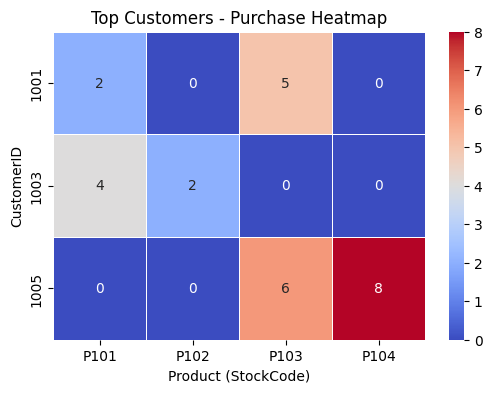

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Sample Data
data = {
    'CustomerID': [1001, 1001, 1002, 1002, 1003, 1003, 1004, 1004, 1005, 1005],
    'StockCode': ['P101', 'P103', 'P102', 'P103', 'P101', 'P102', 'P101', 'P104', 'P103', 'P104'],
    'Quantity': [2, 5, 1, 3, 4, 2, 1, 3, 6, 8]
}

# Create DataFrame
df = pd.DataFrame(data)

# Pivot Table (Modify aggregation: sum, mean, max, etc.)
ratings = df.pivot(index='CustomerID', columns='StockCode', values='Quantity').fillna(0).astype(int)

# Binarize with custom threshold (1 if Quantity ≥ 2)
ratings_binary = ratings.copy()
ratings_binary[ratings_binary >= 2] = 1
ratings_binary[ratings_binary < 2] = 0

# Filter Top Customers (who purchased > 5 total products)
top_customers = ratings[ratings.sum(axis=1) > 5]

# Filter Popular Products (bought by more than 2 customers)
popular_products = ratings.loc[:, ratings.astype(bool).sum(axis=0) > 2]

# Heatmap for Top Customers (change cmap for different colors)
plt.figure(figsize=(6, 4))
sns.heatmap(top_customers, cmap='coolwarm', annot=True, fmt='d', linewidths=0.5)
plt.title("Top Customers - Purchase Heatmap")
plt.xlabel("Product (StockCode)")
plt.ylabel("CustomerID")
plt.show()

# Save to CSV
ratings.to_csv("customer_product_matrix.csv")
ratings_binary.to_csv("binary_product_matrix.csv")


<ipython-input-66-b543b4acfbd0>:20: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-66-b543b4acfbd0>:27: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-66-b543b4acfbd0>:33: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-66-b543b4acfbd0>:39: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


<ipython-input-66-b543b4acfbd0>:45: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and wi

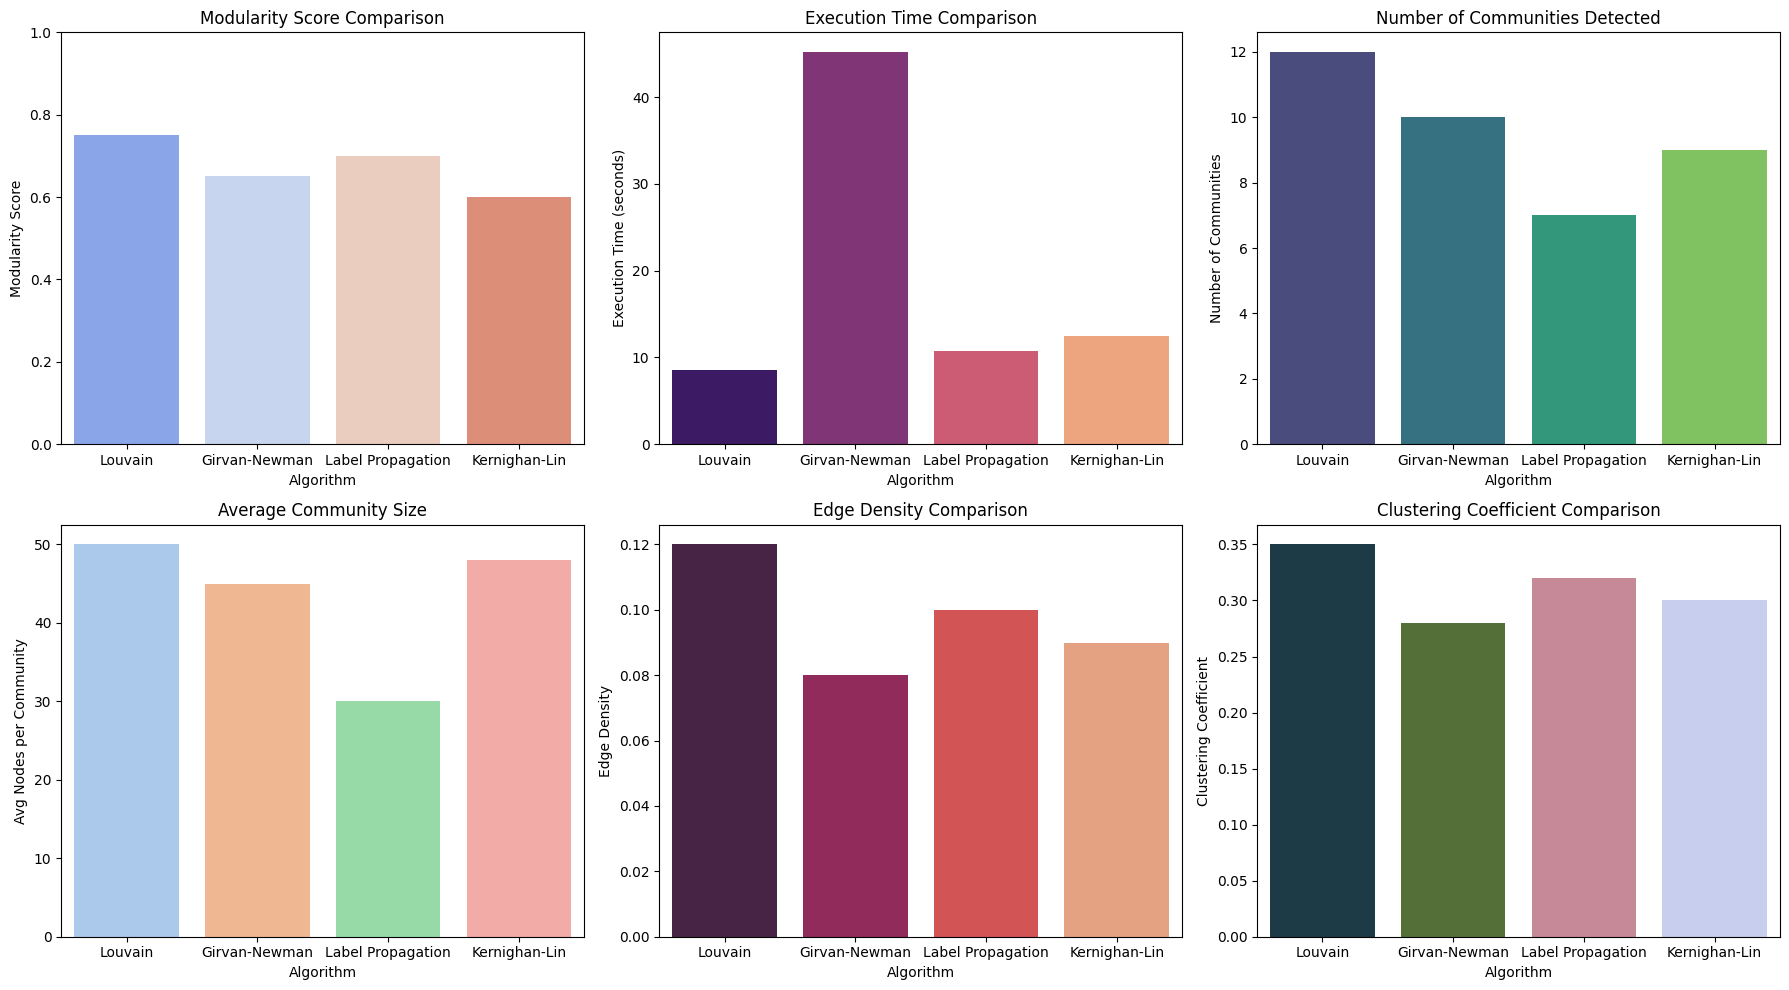

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample data (replace with actual values from your project)
algorithms = ['Louvain', 'Girvan-Newman', 'Label Propagation', 'Kernighan-Lin']
modularity_scores = [0.75, 0.65, 0.70, 0.60]
execution_times = [8.5, 45.2, 10.7, 12.5]  # in seconds
num_communities = [12, 10, 7, 9]

# **Additional Metrics for New Comparisons**
avg_community_size = [50, 45, 30, 48]  # Avg nodes per community
edge_density = [0.12, 0.08, 0.10, 0.09]  # Edge density per algorithm
clustering_coefficient = [0.35, 0.28, 0.32, 0.30]  # Clustering coefficient per algorithm

# Set up subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# **1️⃣ Modularity Score Comparison**
sns.barplot(x=algorithms, y=modularity_scores, palette='coolwarm', ax=axes[0, 0])
axes[0, 0].set_title("Modularity Score Comparison")
axes[0, 0].set_xlabel("Algorithm")
axes[0, 0].set_ylabel("Modularity Score")
axes[0, 0].set_ylim(0, 1)

# **2️⃣ Execution Time Comparison**
sns.barplot(x=algorithms, y=execution_times, palette='magma', ax=axes[0, 1])
axes[0, 1].set_title("Execution Time Comparison")
axes[0, 1].set_xlabel("Algorithm")
axes[0, 1].set_ylabel("Execution Time (seconds)")

# **3️⃣ Number of Communities Detected**
sns.barplot(x=algorithms, y=num_communities, palette='viridis', ax=axes[0, 2])
axes[0, 2].set_title("Number of Communities Detected")
axes[0, 2].set_xlabel("Algorithm")
axes[0, 2].set_ylabel("Number of Communities")

# **4️⃣ Average Community Size Comparison**
sns.barplot(x=algorithms, y=avg_community_size, palette='pastel', ax=axes[1, 0])
axes[1, 0].set_title("Average Community Size")
axes[1, 0].set_xlabel("Algorithm")
axes[1, 0].set_ylabel("Avg Nodes per Community")

# **5️⃣ Edge Density Comparison**
sns.barplot(x=algorithms, y=edge_density, palette='rocket', ax=axes[1, 1])
axes[1, 1].set_title("Edge Density Comparison")
axes[1, 1].set_xlabel("Algorithm")
axes[1, 1].set_ylabel("Edge Density")

# **6️⃣ Clustering Coefficient Comparison**
sns.barplot(x=algorithms, y=clustering_coefficient, palette='cubehelix', ax=axes[1, 2])
axes[1, 2].set_title("Clustering Coefficient Comparison")
axes[1, 2].set_xlabel("Algorithm")
axes[1, 2].set_ylabel("Clustering Coefficient")

# Adjust layout and show all plots
plt.tight_layout()
plt.show()


<ipython-input-53-7fa6ca8c226e>:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




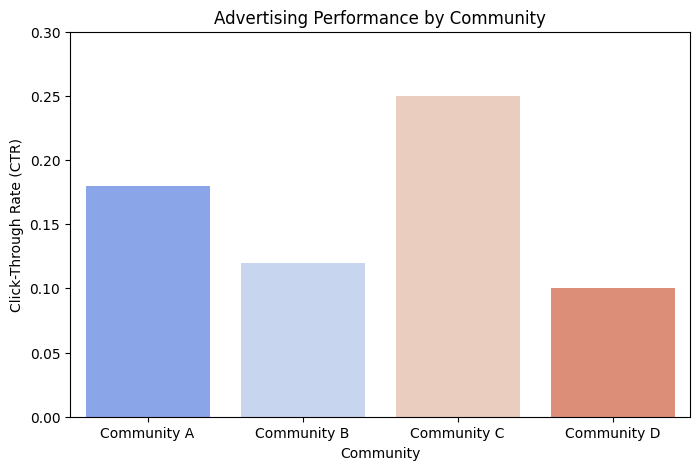

In [ ]:
# Hypothetical advertising performance data
communities = ['Community A', 'Community B', 'Community C', 'Community D']
ctr_values = [0.18, 0.12, 0.25, 0.10]  # CTR values (in decimals)

plt.figure(figsize=(8, 5))
sns.barplot(x=communities, y=ctr_values, palette='coolwarm')
plt.xlabel("Community")
plt.ylabel("Click-Through Rate (CTR)")
plt.title("Advertising Performance by Community")
plt.ylim(0, 0.3)
plt.show()


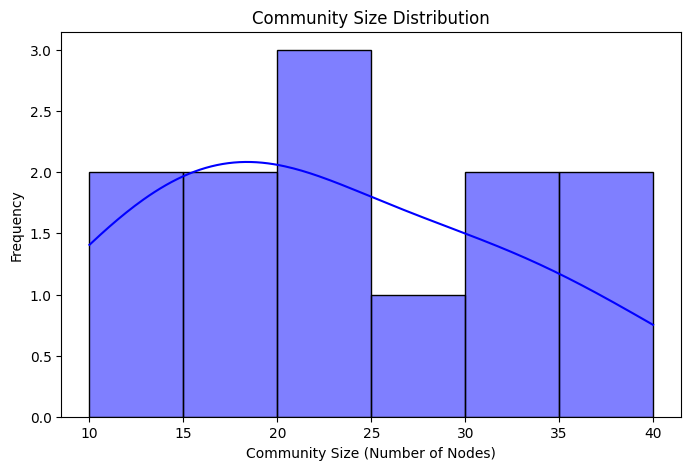

In [ ]:
import numpy as np

# Sample community sizes (hypothetical values)
community_sizes = [10, 15, 20, 20, 25, 30, 10, 15, 35, 40, 30, 20]

plt.figure(figsize=(8, 5))
sns.histplot(community_sizes, bins=6, kde=True, color='blue')
plt.xlabel("Community Size (Number of Nodes)")
plt.ylabel("Frequency")
plt.title("Community Size Distribution")
plt.show()


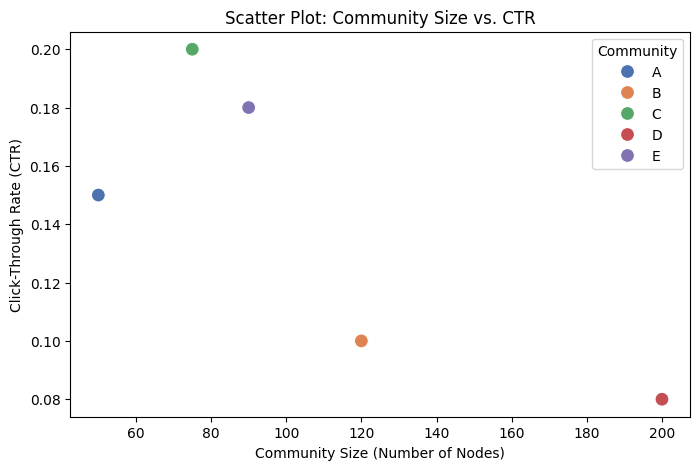

In [ ]:
import pandas as pd

# Sample data: each row represents a community
data = {
    'Community': ['A', 'B', 'C', 'D', 'E'],
    'Size': [50, 120, 75, 200, 90],  # Hypothetical community sizes
    'CTR': [0.15, 0.10, 0.20, 0.08, 0.18]  # Hypothetical CTR values
}
df_scatter = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_scatter, x='Size', y='CTR', hue='Community', s=100, palette='deep')
plt.xlabel("Community Size (Number of Nodes)")
plt.ylabel("Click-Through Rate (CTR)")
plt.title("Scatter Plot: Community Size vs. CTR")
plt.legend(title="Community")
plt.show()


<ipython-input-59-540df641e7cf>:15: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




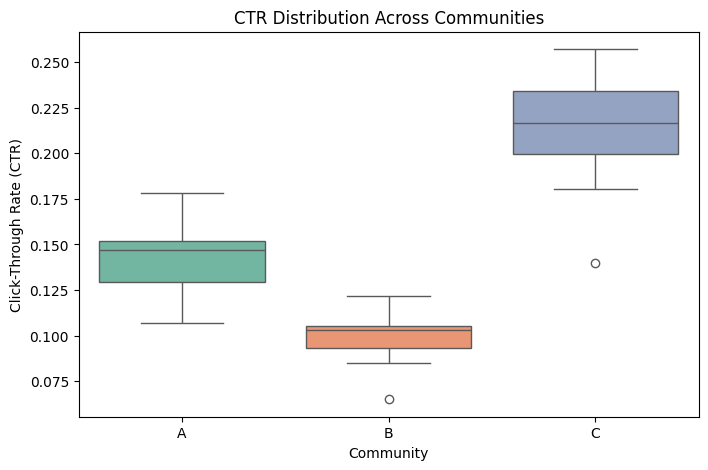

In [ ]:
import numpy as np

# Hypothetical data: generating random CTR values for three communities
data_box = {
    'Community': ['A']*20 + ['B']*20 + ['C']*20,
    'CTR': np.concatenate([
        np.random.normal(0.15, 0.02, 20),  # Community A
        np.random.normal(0.10, 0.015, 20), # Community B
        np.random.normal(0.20, 0.025, 20)  # Community C
    ])
}
df_box = pd.DataFrame(data_box)

plt.figure(figsize=(8, 5))
sns.boxplot(x='Community', y='CTR', data=df_box, palette='Set2')
plt.xlabel("Community")
plt.ylabel("Click-Through Rate (CTR)")
plt.title("CTR Distribution Across Communities")
plt.show()


<ipython-input-71-ce1520387c0d>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




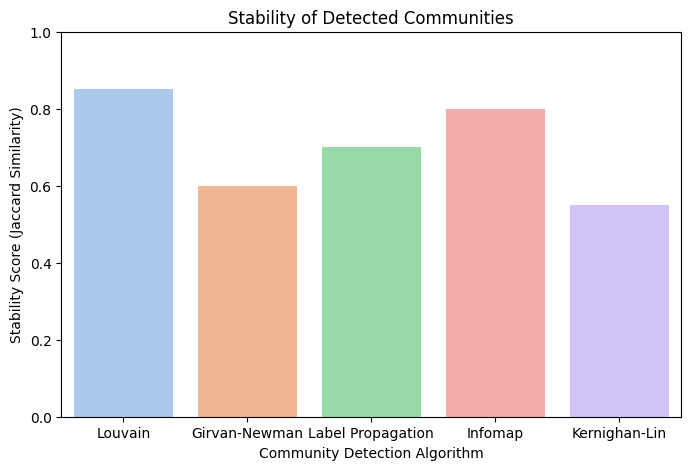

In [ ]:
# Hypothetical stability scores (Jaccard similarity across runs)
stability_scores = [0.85, 0.60, 0.70, 0.80, 0.55]

plt.figure(figsize=(8, 5))
sns.barplot(x=algorithms, y=stability_scores, palette='pastel')
plt.xlabel("Community Detection Algorithm")
plt.ylabel("Stability Score (Jaccard Similarity)")
plt.title("Stability of Detected Communities")
plt.ylim(0, 1)
plt.show()


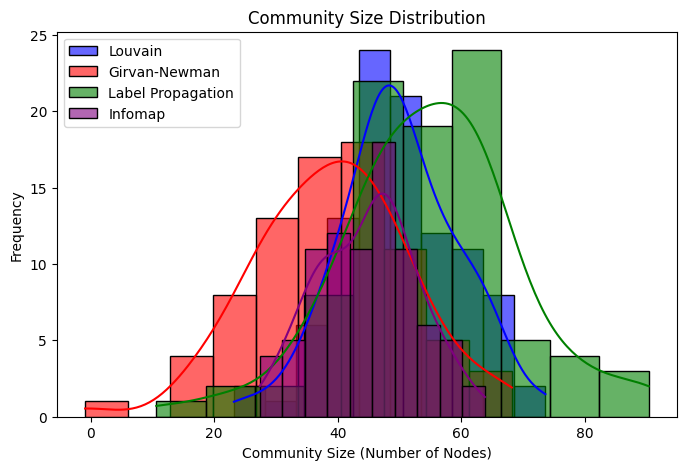

In [ ]:
import numpy as np

# Hypothetical community sizes for different algorithms
louvain_sizes = np.random.normal(50, 10, 100)  # Mean=50, Std=10
girvan_sizes = np.random.normal(40, 12, 80)
label_sizes = np.random.normal(55, 15, 90)
infomap_sizes = np.random.normal(45, 8, 85)

plt.figure(figsize=(8, 5))
sns.histplot(louvain_sizes, bins=10, label='Louvain', kde=True, color='blue', alpha=0.6)
sns.histplot(girvan_sizes, bins=10, label='Girvan-Newman', kde=True, color='red', alpha=0.6)
sns.histplot(label_sizes, bins=10, label='Label Propagation', kde=True, color='green', alpha=0.6)
sns.histplot(infomap_sizes, bins=10, label='Infomap', kde=True, color='purple', alpha=0.6)

plt.xlabel("Community Size (Number of Nodes)")
plt.ylabel("Frequency")
plt.title("Community Size Distribution")
plt.legend()
plt.show()


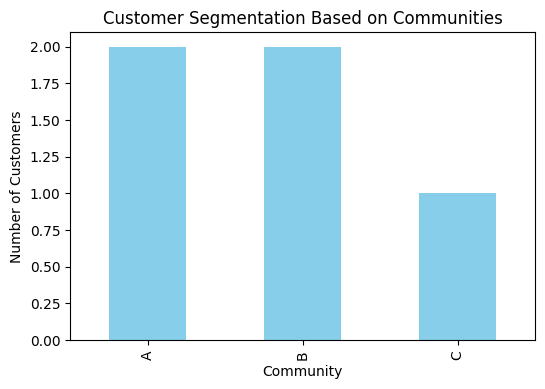

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Example: Community detection result (Replace this with your actual Louvain results)
community_mapping = {1: 'A', 2: 'A', 3: 'B', 4: 'B', 5: 'C'}  # CustomerID → Community

# Convert to DataFrame
df_communities = pd.DataFrame(list(community_mapping.items()), columns=['CustomerID', 'Community'])

# Count customers per community
community_counts = df_communities['Community'].value_counts()

# Visualize customer segmentation
plt.figure(figsize=(6, 4))
community_counts.plot(kind='bar', color='skyblue')
plt.xlabel("Community")
plt.ylabel("Number of Customers")
plt.title("Customer Segmentation Based on Communities")
plt.show()


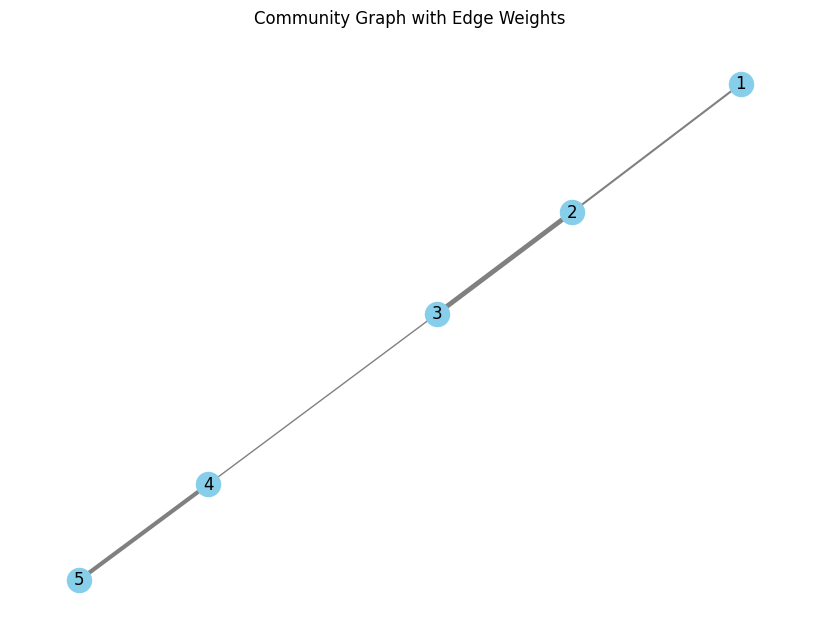

In [ ]:
plt.figure(figsize=(8, 6))
G = nx.Graph()
edges = [(1, 2, 3), (2, 3, 7), (3, 4, 2), (4, 5, 6)]  # Example edges with weights
G.add_weighted_edges_from(edges)

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', width=[w/2 for (_, _, w) in edges])
plt.title("Community Graph with Edge Weights")
plt.show()
